Created on Tuesday 05 January 2021

Group 5 - Classification

@authors : F.B

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/My Drive/G5 Inter-Promo 2021/Données/Input")

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

import warnings
warnings.filterwarnings('ignore')

In [ ]:
data=pd.read_csv('Data_With_Features_Syntax.csv', index_col=0)
data.fillna('', inplace=True)
data.head()

,art_content,art_content_html,art_extract_datetime,art_lang,art_title,art_url,src_name,src_type,src_url,src_img,art_auth,art_tag,Nb_key_words,Nb_key_words_title,Nb_words,Nb_words_title,Nb_sentences,average_word_sentence,ratio_word_title_on_word,exclamation,interrogation,ratio_key_words,ratio_key_sentences,ratio_key_word_title,netloc.com,nb_word_path,content_postive_score,title_postive_score,content_negative_score,title_negative_score,content_polarity_score,title_polarity_score,content_subjectivity_score,title_subjectivity_score
art_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,,,7 décembre 2018,fr,4ème Conférence Nationale de l’Emploi Territor...,http://fncdg.com/4eme-conference-nationale-de-...,FNCDG,xpath_source,http://fncdg.com/actualites/,http://fncdg.com/wp-content/uploads/2018/12/ra...,,,0,0,0,8,0,,inf,0,0,0.000000,0.0,0.0,['.com'],11,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,La FNCDG et l’ANDCDG ont publié en septembre l...,"<p style=""text-align: justify;"">La FNCDG et l’...",22 septembre 2020,fr,9ème édition du Panorama de l’emploi territorial,http://fncdg.com/9eme-edition-du-panorama-de-l...,FNCDG,xpath_source,http://fncdg.com/actualites/,http://fncdg.com/wp-content/uploads/2020/09/im...,,,0,0,40,7,3,13.3333,0.175,0,0,0.000000,0.0,0.0,['.com'],7,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Malgré la levée des mesures de confinement le ...,"<p style=""text-align: justify;"">Malgré la levé...",17 mars 2020,fr,ACTUALITÉS FNCDG / COVID19,http://fncdg.com/actualites-covid19/,FNCDG,xpath_source,http://fncdg.com/actualites/,http://fncdg.com/wp-content/uploads/2020/03/co...,,,2,0,157,4,4,39.25,0.0254777,0,0,0.012739,0.5,0.0,['.com'],2,0.03,0.0,0.0,0.0,0.4,0.0,1.0,0.0
3,,,28 juin 2017,fr,Arrêté de création GIP,http://fncdg.com/arrete-de-creation-gip/,FNCDG,xpath_source,http://fncdg.com/actualites/,http://fncdg.com/wp-content/uploads/2017/05/fo...,,,0,0,0,4,0,,inf,0,0,0.000000,0.0,0.0,['.com'],4,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,,,24 novembre 2017,fr,Article Acteurs Publics « Les centres de gesti...,http://fncdg.com/article-acteurs-publics-les-c...,FNCDG,xpath_source,http://fncdg.com/actualites/,,,,0,0,0,16,0,,inf,0,0,0.000000,0.0,0.0,['.com'],14,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
lexique_innovation :list =[]
with open('/content/drive/My Drive/Colab Notebooks/projet_interpromo_2021/G5 Inter-Promo 2021/Ressources/Lexique_Innovation.txt') as file:
  for line in file:
    lexique_innovation.append(line[:-1])
lexique_innovation[:5]

['innovation', 'devops', 'interopérabilité', 'migration automatique', 'idm']

In [ ]:
def score_innovation(data: pd.DataFrame = data, weight_content: float = 2/3, weight_title:float = 1/3)-> pd.DataFrame:
  ''' This function calculates the score for each document
    Input :
      weight_content : weight of the content
      weight_title : weight of the title
    Output:
      data : dataframe with the innovation score column 
  '''
  # centred and reduced
  dd=scaler.fit_transform(data[['Nb_key_words','Nb_key_words_title']])
  data['Nb_key_words']=dd[:,0]
  data['Nb_key_words_title']=dd[:,1]

  # calculate the score 
  data['innovation'] = data['Nb_key_words']*weight_content + data['Nb_key_words_title']*weight_title # innovation score 

  # Extend over the interval 0 and 1
  i=max(data['innovation'].values)
  j=min(data['innovation'].values)
  data['innovation']=(data['innovation'] - j)/(i - j)

  return data

In [ ]:
def classification_innovation( score_threshold : tuple) -> int:
  ''' This function classifies each document, 1 if it is innovative 0 otherwise
     Input :
        score_threshold : tuple containing the score and the threshold 
  '''
  score, threshold = score_threshold[0], score_threshold[1]
  if score <= threshold:
    return 0
  else:
    return 1


In [ ]:
def classification_innovation_2(data: pd.DataFrame = data, weight_content: float = 2/3, weight_title:float = 1/3, threshold:float = 0.5)-> pd.DataFrame :
  ''' This function calculates the innovation score and then classifies each document. 
    Input:
      threshold : threshold
      weight_content : weight of the content
      weight_title : weight of the title
    Output:
      data : dataframe with the innovation score column 
  '''
  data = score_innovation(data, weight_content, weight_title)
  data['innovation']=list(zip(data['innovation'].values, np.repeat(threshold,len(data))))
  data['innovation']=data['innovation'].apply(classification_innovation)
  return data

data=classification_innovation_2()

In [ ]:
len(data[data['innovation']==1])

129

In [ ]:
len(data[data['innovation']==0])

12017

In [ ]:
len(data)

12146

# Prediction

In [ ]:
tf_idf=pd.read_csv('TF-IDF.csv')
tf_idf=tf_idf[tf_idf.index.isin(data.index)] # retrieve the tf_idf of french documents
tf_idf.head()

,000,01,02,03,04,06,07,08,09,10,100,1000,11,110,118,11h,12,120,13,14,15,150,1500,16,17,18,180,19,1997,1998,1999,1er,20,200,2000,2001,2002,2003,2004,2005,...,étendue,éthique,étions,étranger,étrangers,étrangères,étroite,étroitement,étude,études,étudiant,étudiants,étudier,été,évaluation,évaluer,évalué,éventuellement,éventuelles,évidemment,évidence,évident,éviter,évolue,évoluent,évoluer,évolutif,évolution,évolutions,évolué,évoque,évoquer,évoqué,événement,événements,êtes,être,île,œuvre,art_id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [ ]:
y=data.innovation.values

In [ ]:
def training(y: np.ndarray, model, if_plot : bool =False)-> np.ndarray:
  ''' This function trains a model, calculates and displays its score 
      and returns its confusion matrix.
    Input : y : 
            model : model
    Output :
      confusion matrix
  '''
  X_train, X_val, Y_train, Y_val = train_test_split (tf_idf, y, test_size = 0.30, random_state = 40) 
  model.fit(X_train, Y_train)
  y_pred = model.predict(X_val)

  if if_plot:
    plot_confusion_matrix(model, X_val, Y_val, cmap='Blues', normalize=None,
                     display_labels=['No innovation', 'Innovation']);

  return f1_score(Y_val, y_pred), model.score(X_val, Y_val)

(0.8, 0.9961580680570802)

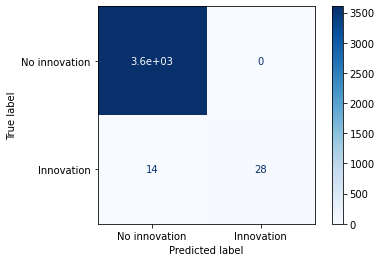

In [ ]:
# Logistic Regression 
model=LogisticRegression()
training(y , model, True)

(0.923076923076923, 0.9983534577387486)

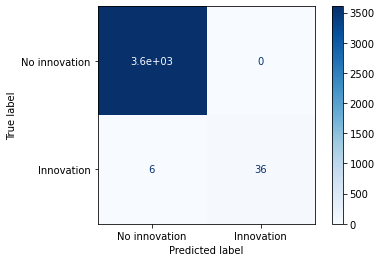

In [ ]:
# Random Forest
model=RandomForestClassifier()
training(y , model, True)

# Optimum threshold search

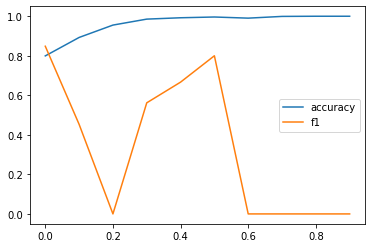

In [ ]:
# Logistic Regression 

list_threshold =np.arange(0,11)/10
scores_accuracy :list=[]
scores_f1 :list=[]

list_threshold_ :list=[]

for threshold in list_threshold:

  data=classification_innovation_2(threshold=threshold)

  y=data.innovation.values
  try:
    s=training(y, LogisticRegression())
    scores_accuracy.append(s[1])
    scores_f1.append(s[0])
    list_threshold_.append(threshold)
  except:
    pass


plt.plot(list_threshold_, scores_accuracy, label='accuracy')
plt.plot(list_threshold_, scores_f1, label='f1')
plt.legend()
plt.show()

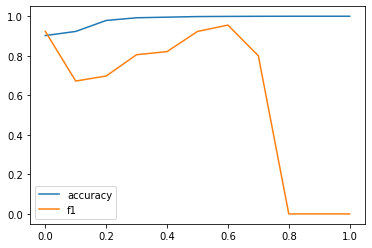

In [ ]:
# Random Forest

list_threshold=np.arange(0,11)/10

scores_accuracy : list = []
scores_f1 : list = []
list_threshold_ : list = []

for threshold in list_threshold:

  data=classification_innovation_2(threshold=threshold)

  y=data.innovation.values
  try:
    s=training(y, RandomForestClassifier())
    scores_accuracy.append(s[1])
    scores_f1.append(s[0])
    list_threshold_.append(threshold)
  except:
    pass


plt.plot(list_threshold_, scores_accuracy, label='accuracy')
plt.plot(list_threshold_, scores_f1, label='f1')
plt.legend()
plt.show()

In [ ]:
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import AdaBoostClassifier

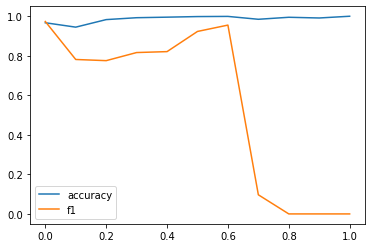

In [ ]:
# lgbm

list_threshold=np.arange(0,11)/10

scores_accuracy :list=[]
scores_f1 :list=[]
list_threshold_ :list=[]

for threshold in list_threshold:

  data=classification_innovation_2(threshold=threshold)

  y=data.innovation.values
  try:
    s=training(y, LGBMClassifier())
    scores_accuracy.append(s[1])
    scores_f1.append(s[0])
    list_threshold_.append(threshold)
  except:
    pass


plt.plot(list_threshold_, scores_accuracy, label='accuracy')
plt.plot(list_threshold_, scores_f1, label='f1')
plt.legend()
plt.show()

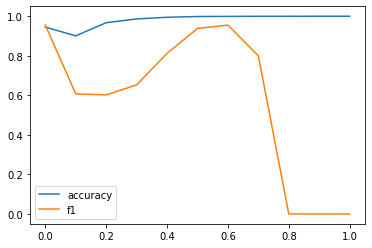

In [ ]:
# Adaboost

list_threshold=np.arange(0,11)/10

scores_accuracy :list=[]
scores_f1 :list=[]
list_threshold_ :list=[]

for threshold in list_threshold:

  data=classification_innovation_2(threshold=threshold)

  y=data.innovation.values
  try:
    s=training(y, AdaBoostClassifier())
    scores_accuracy.append(s[1])
    scores_f1.append(s[0])
    list_threshold_.append(threshold)
  except:
    pass


plt.plot(list_threshold_, scores_accuracy, label='accuracy')
plt.plot(list_threshold_, scores_f1, label='f1')
plt.legend()
plt.show()

# Cross-validation with optimum threshold

In [ ]:
threshold_opt:float = 0.6
data=classification_innovation_2(threshold = threshold_opt)
y=data.innovation.values

print("accuracy ...")
model = RandomForestClassifier ()
cross_val_score(model, tf_idf, y, cv=5)

accuracy ...


array([0.9909465 , 0.99835323, 1.        , 1.        , 1.        ])

In [ ]:
print("f1_score ...")

model = RandomForestClassifier ()
cross_val_score(model, tf_idf, y, cv=5, scoring='f1')

f1_score ...


array([0.        , 0.89473684, 1.        , 1.        , 1.        ])

# Impacts weight_content and weight_title

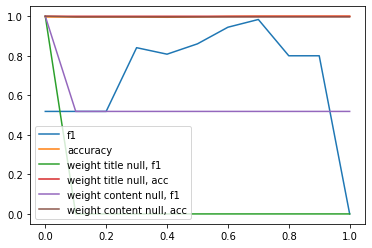

In [ ]:
scores_accuracy :list = []
scores_f1 :list = []

scores_awt :list = []
scores_fwt :list = []
weights_wt :list = []

scores_awc :list = []
scores_fwc :list = []
weights_wc :list = []

weights = np.arange(0,11)/10

for w in weights:

  ## 
  data=classification_innovation_2(weight_content=w, weight_title=1-w, threshold=threshold_opt)
  y=data.innovation.values  
  s=training(y, RandomForestClassifier())
  scores_accuracy.append(s[1])
  scores_f1.append(s[0])


  ## weight_title null
  data=classification_innovation_2(weight_content=w, weight_title=0, threshold=threshold_opt)
  y=data.innovation.values
  try:
    s=training(y, RandomForestClassifier())
    scores_awt.append(s[1])
    scores_fwt.append(s[0])
    weights_wt.append(w)
  except:
    pass

  ## weight_content null
  data=classification_innovation_2(weight_content=0, weight_title=w, threshold=threshold_opt)
  y=data.innovation.values
  try:
    s=training(y, RandomForestClassifier())
    scores_awc.append(s[1])
    scores_fwc.append(s[0])
    weights_wc.append(w)
  except:
    pass



plt.plot(weights, scores_f1, label='f1')
plt.plot(weights, scores_accuracy, label='accuracy')


plt.plot(weights_wt, scores_fwt, label='weight title null, f1')
plt.plot(weights_wt, scores_awt, label='weight title null, acc')

plt.plot(weights_wc, scores_fwc, label='weight content null, f1')
plt.plot(weights_wc, scores_awc, label='weight content null, acc')


plt.legend()
plt.show()

#  Label

In [ ]:
weight_content_opt : float = 0.7
weight_title_opt : float = 0.3


data=classification_innovation_2(weight_content= weight_content_opt, weight_title=weight_title_opt, threshold = threshold_opt)
y=data.innovation.values

print('accurracy ...')
cross_val_score(RandomForestClassifier(), tf_idf, y, cv=5)

accurracy ...


array([0.99259259, 1.        , 1.        , 1.        , 1.        ])

In [ ]:
print('f1_score ...')
cross_val_score(RandomForestClassifier(), tf_idf, y, cv=5, scoring='f1')

f1_score ...


array([0.25, 1.  , 1.  , 1.  , 1.  ])

(0.9836065573770492, 0.9997255762897914)

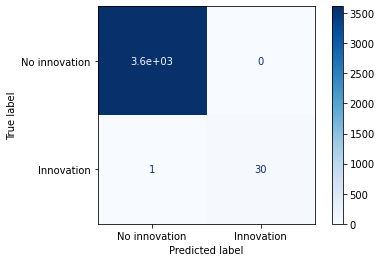

In [ ]:
training(y, RandomForestClassifier(), True)

In [ ]:
label=pd.DataFrame(y,columns=['label'])
label.index=data.index
label.head()

,label
art_id,
0,0
1,0
2,0
3,0
4,0


In [ ]:
label.to_csv('../Output/Innovation/g5_FB_label_v1.csv', index=True)